In [1]:
import sys, os
sys.path.append('src')
import numpy as np
from tqdm import tqdm
from scipy.stats import permutation_test
import matplotlib.pyplot as plt
from models import *
from train_funcs import *
from visualization import *
rng = np.random.default_rng()

## File Data

In [2]:
AUD_MAP_TYPE = 'neighbor'
HVC_COND = 'mature_hvc'
# HVC_COND = 'developing_hvc'
REC_PLASTICITY = 'EIIE'
POSTFIX = '_'.join([AUD_MAP_TYPE, REC_PLASTICITY, HVC_COND])
IMG_DIR = 'svg/different_models/'
SONG_EMB_DIR = 'realistic_auditory_processing/learned_song_responses.npz'

## Constants

In [3]:
NE, NI, N_HVC = 600, 150, 15
PEAK_RATE, KERNEL_WIDTH = 150, 20
dt = 1

aud_real = np.load(SONG_EMB_DIR)
PERT_T0 = int(np.round(aud_real['pert_t0'].min(), -1))
PERT_T1 = int(np.round(aud_real['pert_t1'].max(), -1)) + 100

T_burn = 500 # Burning
T_pre = 100 # time period to keep before song
T_post = 200 # Silence after song
T_song = aud_real['ctrl'].shape[2]
T_rend = T_song + T_post # Each rendition
T_test = T_burn+T_rend

N_test_rend = 10

_ = np.arange(N_test_rend)
burst_ts = np.linspace(_*T_rend+T_burn, _*T_rend+T_burn+T_song, num=N_HVC, endpoint=False)
_ = np.zeros((N_HVC, N_test_rend)) # auxilliary
rH = generate_HVC(T_test, burst_ts, PEAK_RATE+_, KERNEL_WIDTH+_)

cases = ('ctrl', 'pert')
aud_args = (N_test_rend, T_burn, T_post, None, False)

## Simulations

In [5]:
N_trials = 3
res = {k: [np.zeros((N_trials*N_test_rend,T_pre+T_rend,NE+i)) 
           for i in (0,NI,NI,NI)] for k in cases} 
for tid in range(N_trials):
    _ = load_models('results/', AUD_MAP_TYPE, REC_PLASTICITY, HVC_COND, tid)
    nets, aud_mapping = _[:4], _[-1]
    
    aud_real, _ = read_realistic_input(SONG_EMB_DIR, NE, mean=0, scale=2, 
                                       mapping=aud_mapping, mapping_args=None)
    aud_ctrl, aud_ctrl_idx = generate_realistic_aud(aud_real['ctrl'], *aud_args)
    
    args = (N_test_rend, T_burn, T_post, None, False)
    aud_real_pert = aud_real['ctrl'].copy()
    xi_new = aud_mapping.T @ rng.normal(size=(100,1), scale=2)
    # xi_new = rng.normal(size=(NE,1), scale=2)
    for i in range(aud_real_pert.shape[0]):
        t0 = int(aud_real['pert_t0'][i]) + T_pre
        aud_real_pert[i,:,t0:t0+50] = xi_new
    aud_pert, aud_pert_idx = generate_realistic_aud(aud_real_pert, *args)
    
    auds = (aud_ctrl, aud_pert)
    
    hE0 = rng.normal(loc=-10, scale=0.5, size=NE)
    hI0 = rng.normal(loc=-1, scale=0.5, size=NI)
    
    for k, a in tqdm(zip(cases, auds), total=len(cases)):
        for i in range(a.shape[0]): # for each case, enumerate over songs
            rH_ = rH[:T_test] if k != 'playback' else rH[:T_test]*0
            args = dict(rH=rH_, aud=a[i], save_W_ts=[], T=T_test, dt=dt, 
                        noise_strength=0.1, no_progress_bar=True)

            # FF
            res[k][0][tid*N_test_rend+i] = np.hstack(nets[0].sim(hE0, **args)[:1])[T_burn-T_pre:]
            
            for j, net in enumerate(nets[1:], start=1): # EI nets
                res[k][j][tid*N_test_rend+i] = np.hstack(net.sim(hE0, hI0, **args)[:2])[T_burn-T_pre:]

100%|█████████████████████████████████████████████| 2/2 [00:23<00:00, 11.92s/it]


## Analysis

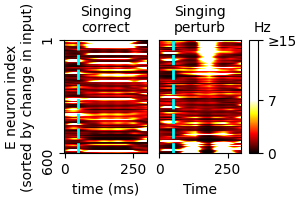

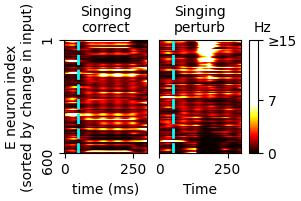

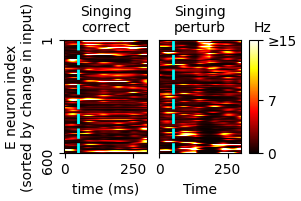

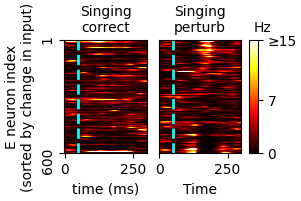

In [6]:
i = 0
titles = ['Singing\ncorrect', 'Singing\nperturb']
syl = aud_real['ctrl'][:,:,PERT_T0:PERT_T1].mean(axis=(0,2))
for l, m in enumerate(('FF', 'EI', 'EIrecEE', 'EIrecEI')):
    _ = [res[k][l][-1,:,:NE] for k in ('ctrl', 'pert')]
    t0 = int(aud_real['pert_t0'][i]) + T_pre
    bos_ctrl = aud_real['ctrl'][i,:,t0:t0+50].mean(axis=1)
    err = [bos_ctrl - syl, np.squeeze(xi_new) - syl]
    fig, ax = plot_raster_cmp_syl_dsyl(_, titles, syl, err, t0, t0+250,
                                       figsize=(3, 2), plot_z=False, sort_by='e', th=15, tpre=50) 
    # for j in range(len(ax)-1):
    #     ax[j].set(xticks=[100, 250], xticklabels=[0, 150], xlabel='')
    ax[0].set(xlabel='time (ms)')
    fig.savefig(os.path.join(IMG_DIR, 'subsyl_err_response_%s_%s.svg' % (m, POSTFIX)))

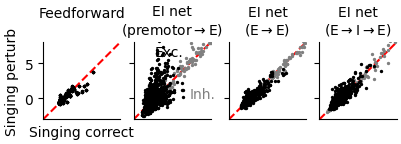

In [7]:
fig, ax = plt.subplots(1, 4, figsize=(4, 2), sharex='all', sharey='all')
# t0, t1 = T_pre + PERT_T0, T_pre + PERT_T1
t0, t1 = T_pre, T_pre + T_song
for i in range(4): 
    z_ctrl = res['ctrl'][i][:,t0:t1].mean(axis=(0,1))
    m, s = z_ctrl[:NE].mean(), z_ctrl[:NE].std()
    z_ctrl = (z_ctrl - m) / s
    
    z_pert = res['pert'][i][:,t0:t1].mean(axis=(0,1))
    z_pert = (z_pert - m) / s
    
    ax[i].scatter(z_ctrl[NE:], z_pert[NE:], s=8, c='grey', zorder=-2)
    ax[i].scatter(z_ctrl[:NE], z_pert[:NE], s=8, c='k', zorder=-1)
    ax[i].plot([-3, 50], [-3,50], c='r', ls='--', zorder=-3)
    ax[i].set_rasterization_zorder(0)
    ax[i].set(aspect=1, ylim=[-3,8], xlim=[-3,8], xticks=[])
        
ax[1].text(0, 6, 'Exc.', c='k', zorder=1)
ax[1].text(5, 0, 'Inh.', c='grey', zorder=1)
ax[0].set(xlabel='Singing correct')
ax[0].set_ylabel('Singing perturb')
ax[0].set_title('Feedforward\n', fontsize=10)
ax[1].set_title('EI net\n(premotor$\\to$E)', fontsize=10)
ax[2].set_title('EI net\n(E$\\to$E)', fontsize=10)
ax[3].set_title('EI net\n(E$\\to$I$\\to$E)', fontsize=10)
fig.savefig(os.path.join(IMG_DIR, 'subsyl_learn_real_joint_dist_%s.svg' % POSTFIX), dpi=300)

1.0
3.9451413727208175e-21
0.9125067617734065
1.4629586578615726e-07


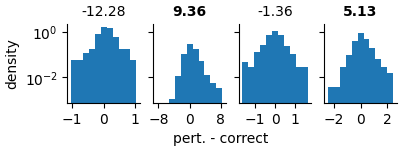

In [8]:
from scipy.stats import wilcoxon, skewtest
fig, ax = plt.subplots(1, 4, figsize=(4, 1.5), sharey='all')
ls = ['Feedforward\n', 'EI net\n(premotor$\\to$E)', 
      'EI net\n(E$\\to$E)', 'EI net\n(E$\\to$I$\\to$E)']
# t0, t1 = T_pre + PERT_T0, T_pre + PERT_T1
t0, t1 = T_pre, T_pre + T_song
for i, l in enumerate(ls): 
    z_ctrl = res['ctrl'][i][:,t0:t1].mean(axis=(0,1))
    z_pert = res['pert'][i][:,t0:t1].mean(axis=(0,1))
    m, s = z_ctrl[:NE].mean(), z_ctrl[:NE].std()
    z_ctrl = (z_ctrl - m) / s
    z_pert = (z_pert - m) / s
    diff = z_pert - z_ctrl
    diff = diff[:NE]
    test = skewtest(diff, alternative='greater')
    pval = test.pvalue
    print(pval)
    m = max(-diff.max(), diff.max(), 1)
    ax[i].hist(diff, bins=11, range=(-m, m), density=True)
    ax[i].set(xticks=[-int(m), 0, int(m)])
    ax[i].set_title('%.2f' % test.statistic, 
                    fontweight='bold' if test.statistic>0 else 'normal')
ax[0].set(xlabel=' ', ylabel='density', yscale='log')
fig.text(0.55, 0.05, 'pert. - correct', ha='center')
fig.savefig(os.path.join(IMG_DIR, 'subsyl_pert_diff_models_%s.svg' % POSTFIX))

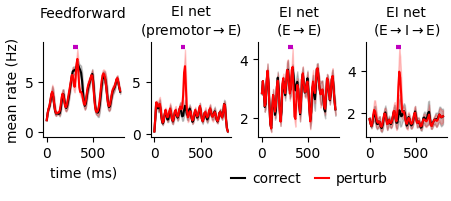

In [9]:
fig, ax = plt.subplots(1, 4, figsize=(4.5,2))
ls = ['Feedforward\n', 'EI net\n(premotor$\\to$E)', 
      'EI net\n(E$\\to$E)', 'EI net\n(E$\\to$I$\\to$E)']
ts = np.arange(0, T_song, 10)
for i, k in enumerate(ls):
    for j, c in zip(('ctrl', 'pert'), ('k', 'r')):
        aux = res[j][i][:,T_pre:-T_post:10,:NE].mean(axis=-1)
        plot_mean_std(ax[i], aux.mean(axis=0), aux.std(axis=0), 0.2, c, xs=ts)
    ax[i].set_rasterization_zorder(1.4)
    ax[i].set(title=k)
    
m = aud_real['pert_t0'].mean() + T_pre
for i in range(4):
    ax[i].hlines(ax[i].get_ylim()[1]-0.1, m, m+50, lw=3, color='m')
ax[0].set(xlabel='time (ms)\n', ylabel='mean rate (Hz)')
for k, c in zip(('correct', 'perturb'), ('k', 'r')):
    ax[0].plot(0,0, c=c, label=k)
fig.legend(ncols=2, loc=(0.5, 0.05), labelspacing=0.5)
fig.savefig(os.path.join(IMG_DIR, 'subsyl_learn_real_mean_rates_%s.svg' % POSTFIX))

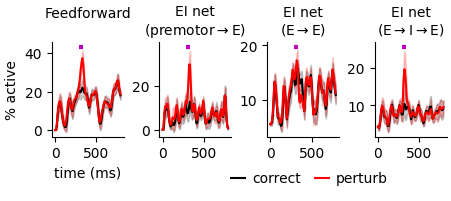

In [10]:
fig, ax = plt.subplots(1, 4, figsize=(4.5,2))
ls = ['Feedforward\n', 'EI net\n(premotor$\\to$E)', 
      'EI net\n(E$\\to$E)', 'EI net\n(E$\\to$I$\\to$E)']
ts = np.arange(0, T_song, 10)
for i, k in enumerate(ls):
    for j, c in zip(('ctrl', 'pert'), ('k', 'r')):
        aux = (res[j][i][:,T_pre:-T_post:10,:NE] > 5).mean(axis=-1) * 100
        plot_mean_std(ax[i], aux.mean(axis=0), aux.std(axis=0), 0.2, c, xs=ts)
    ax[i].set_rasterization_zorder(1.4)
    ax[i].set(title=k)
    
m = aud_real['pert_t0'].mean() + T_pre
for i in range(4):
    ax[i].hlines(ax[i].get_ylim()[1]-0.1, m, m+50, lw=3, color='m')
ax[0].set(xlabel='time (ms)\n', ylabel='% active')
for k, c in zip(('correct', 'perturb'), ('k', 'r')):
    ax[0].plot(0,0, c=c, label=k)
fig.legend(ncols=2, loc=(0.5, 0.05), labelspacing=0.5)
fig.savefig(os.path.join(IMG_DIR, 'subsyl_learn_real_sparsity_%s.svg' % POSTFIX))

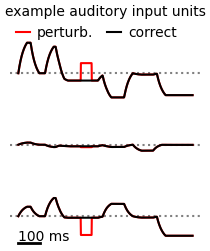

In [11]:
fig, ax = plt.subplots(3, figsize=(2, 2.5), sharex='all', sharey='all')
idx = np.sort(rng.integers(0, NE, size=3))
for i, j in enumerate(idx):
    ax[i].axhline(0, ls=':', c='grey')
    ax[i].plot(aud_real_pert[0,j], c='r', label='perturb.' if i == 0 else '')
    ax[i].plot(aud_real['ctrl'][0,j], c='k', label='correct' if i == 0 else '')
    ax[i].set_axis_off()
ax[0].set(title='example auditory input units\n')
y = ax[-1].get_ylim()[0]
ax[-1].plot([0, 100], [y, y], c='k', lw=2)
ax[-1].text(0, y, '100 ms', va='bottom')
fig.legend(loc=(0.05, 0.82), ncols=2)
fig.savefig(os.path.join(IMG_DIR, 'subsyl_pert_input_%s.svg' % POSTFIX))